## Comprehensive Sentiment Analysis Using Different Methods

This notebook presents a comprehensive approach to sentiment analysis using different NLP models. The analysis progresses from basic methods to more advanced neural network-based approaches.

### TABLE OF CONTENTS
- [Part 1 Pre-processing](#preprocessing)
- [Part 2 Simple classification models](#simple-classification-models)
- [Part 3 Transformer- based models](#transformer-based-models)
- [Preditction](#prediction)

In [1]:
import numpy as np
import pandas as pd
import random
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.nn import CrossEntropyLoss

import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, accuracy_score
import re

from nltk.tokenize import TweetTokenizer, word_tokenize
import preprocessing
import pickle
import spacy
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics, model_selection, naive_bayes
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler


preprocess_tweet Yo, cannabis alcohol other substances celebratory fashion first place night German ' lit! b.c maine German ' angry up,  person name fit lad German ' drugs willing point.  Shorthand German ' person best marijuana German conversation Berliner society matrons bangers, word]Valley slayed. chance cap,  German '   night ever. YOLO!


## Preprocessing

In [2]:
# the preprocessing method 
def remove_patterns(text):
    # lower the text
    text = text.lower()
    # Remove '<user>'
    text = re.sub(r'<user>', '', text)
    # Remove '<url>'
    text = re.sub(r'<url>', '', text)
    # remove number
    text = re.sub(r'\d+', '', text)
    return text

Below is another preprocessing method: convert slangs, but it doesn't perform well in our model, so we don't apply it to our final model.

In [ ]:
# !python3 -m spacy download en_core_web_sm

In [8]:
def set_up():
    # Load spaCy's English model
    nlp = spacy.load('en_core_web_sm')

    # Load the urban dictionary dataset
    # since this csv file is too big to push it to github, you can find the file here
    # https://www.kaggle.com/datasets/therohk/urban-dictionary-words-dataset
    file_path = 'data/urbandict-word-defs.csv'
    try:
        slang_df = pd.read_csv(file_path, on_bad_lines='skip')
    except AttributeError:
        slang_df = pd.read_csv(file_path, error_bad_lines=False)

# Function to extract meaningful words from definitions
def extract_meaningful_words(definition):
    # Ensure the definition is a string
    if not isinstance(definition, str):
        return ''
    doc = nlp(definition)
    meaningful_words = [token.text for token in doc if token.pos_ in ['NOUN', 'ADJ'] and token.text.lower() not in ['word', 'words', 'people', 'something']]
    return ' '.join(meaningful_words)

# Function to preprocess tweets
def replace_slang(tweet, slang_df):
    words = tweet.split()
    processed_words = []

    for word in words:
        # Find the slang definitions in the DataFrame
        word_definitions = slang_df[slang_df['word'] == word.lower()]['definition']

        # Process the definitions
        for definition in word_definitions:
            processed_definition = extract_meaningful_words(definition)
            if len(processed_definition.split()) <= 5:
                processed_words.append(processed_definition)
                break
        else:
            # Append the original word if no suitable definition is found
            processed_words.append(word)

    # Join the words back into a processed tweet
    processed_tweet = ' '.join(processed_words)
    return processed_tweet

# Example tweet
def example_use():

    tweet = "Yo, that party last night was lit! Everyone was turnt up, the vibe was on point. The DJ was dropping bangers after bangers, totally slayed. No cap, it was the best night ever. YOLO!"
    # Preprocess the example tweet
    preprocessed_tweet = replace_slang(tweet, slang_df)

    # Output the preprocessed tweet
    print("preprocess_tweet", preprocessed_tweet)


## Simple classification models

In [7]:
# Naive Bayes classifier for multinomial models
model_0 = naive_bayes.MultinomialNB(alpha=0.01)  # Smoothing parameter
# Logistic Regression
model_1 = linear_model.LogisticRegression(C=1.0, max_iter=200, solver='liblinear')  # Regularization strength, max iterations, solver
# Random Forest Classifier
model_2 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)  # Number of trees, depth of trees, random seed
# Decision Tree Classifier
model_3 = DecisionTreeClassifier(max_depth=5, min_samples_split=4, random_state=42)  # Maximum depth of the tree, minimum number of samples required to split an internal node


# Create a list of models
model_list = [model_0, model_1, model_2, model_3]
model_list

[MultinomialNB(alpha=0.01),
 LogisticRegression(max_iter=200, solver='liblinear'),
 RandomForestClassifier(max_depth=10, random_state=42),
 DecisionTreeClassifier(max_depth=5, min_samples_split=4, random_state=42)]

In [8]:
def train_model(models, embedding, train_df, test_df):
    plt.figure(figsize=(8, 6))
    for this_model in models:
        vec = embedding
        vec.fit(train_df.text)
        xtrain = vec.transform(train_df.text) 
        xtest = vec.transform(test_df.text)
        model = this_model
        model.fit(xtrain, train_df.sentiment)
        pred_probs = model.predict_proba(xtest)[:, 1]
        if(this_model != model_3):
            fpr, tpr, thresholds = roc_curve(test_df.sentiment, pred_probs)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{str(this_model)} (AUC = {roc_auc:.2f})')
        preds = model.predict(xtest)
        accuracy = metrics.accuracy_score(test_df.sentiment, preds)
        f1 = f1_score(test_df.sentiment, preds)
        print("model:", str(this_model))
        print(f"Accuracy = {accuracy}")
        print(f"F1 Score = {f1}")
        print("")
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) curves')
    plt.legend()
    plt.show()

In [9]:
pos_path = 'data/twitter-datasets/train_pos.txt'
neg_path = 'data/twitter-datasets/train_neg.txt'
with open(pos_path, 'r') as f:
    pos = f.readlines()
pos = [remove_patterns(tweet.rstrip('\n')) for tweet in pos]
with open(neg_path,'r') as f:
    neg = f.readlines()
neg = [remove_patterns(tweet.rstrip('\n')) for tweet in neg]
pos_df = pd.DataFrame({'text': pos, 'sentiment': 1})
neg_df = pd.DataFrame({'text': neg, 'sentiment': -1})
df = pd.concat([pos_df, neg_df], axis=0) 
shuffled_df = df.sample(frac=1).reset_index(drop=True)
y = shuffled_df.sentiment.values
train_size = int(len(shuffled_df) * 0.8)
train_df = shuffled_df.sample(n=train_size, random_state=42)
test_df = shuffled_df.drop(train_df.index)

#### Count Vectorizing (Bags of words)

model: MultinomialNB(alpha=0.01)
Accuracy = 0.739075
F1 Score = 0.7720830694647655

model: LogisticRegression(max_iter=200, solver='liblinear')
Accuracy = 0.82725
F1 Score = 0.8332126478397296

model: RandomForestClassifier(max_depth=10, random_state=42)
Accuracy = 0.71415
F1 Score = 0.761174701311722

model: DecisionTreeClassifier(max_depth=5, min_samples_split=4, random_state=42)
Accuracy = 0.71385
F1 Score = 0.731011468321113



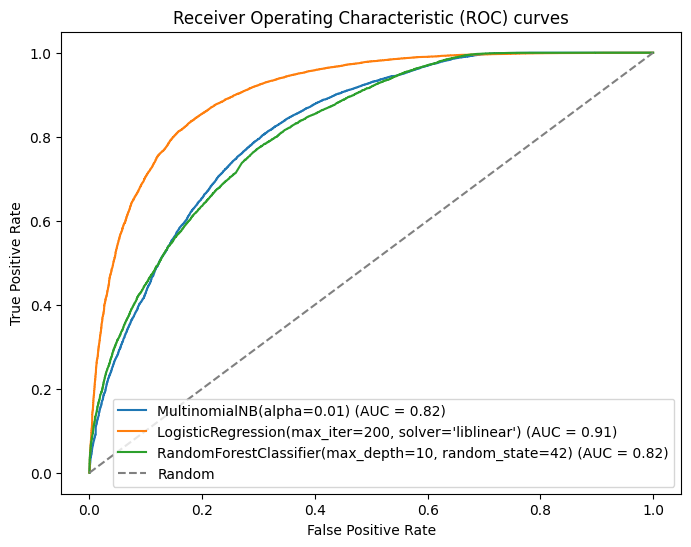

In [10]:
emb = CountVectorizer( 
        tokenizer=word_tokenize, 
        token_pattern=None
    )
train_model(model_list,emb,train_df,test_df)

#### GloVe Embedding

In [11]:
def pad_sequences(vectors, maxlen, dtype='float32'):
    """Pads sequences of word vectors to the same length with zero vectors."""
    # The padding value is a vector of zeros with the same width as the embeddings
    padding_value = np.zeros_like(vectors[0][0], dtype=dtype)
    
    for i in range(len(vectors)):
        print(vectors[i].shape)

    if(len(vectors[0].shape) == 1):
        padded_sequences = np.zeros((len(vectors), maxlen), dtype=dtype)
    else:
        padded_sequences = np.zeros((len(vectors), maxlen, vectors[0].shape[1]), dtype=dtype)
    
    for i, sequence in enumerate(vectors):
        for j, vector in enumerate(sequence):
            if j < maxlen:
                padded_sequences[i, j] = vector
                
    return padded_sequences

def handle_uneven_sequences(sequences, maxlen=None, dtype='float32'):
    """Pads or truncates sequences of word vectors to the same length."""
    # If maxlen is not provided, use the length of the longest sequence
    if maxlen is None:
        if not isinstance(sequences[0], list):
            maxlen = max([sequence.shape[0] for sequence in sequences])
        else:
            maxlen = max([len(sequence) for sequence in sequences])
    
    padded_sequences = pad_sequences(sequences, maxlen, dtype=dtype)
    
    return padded_sequences

(111, 20)
(116, 20)
(98, 20)
(70, 20)
(96, 20)
(25, 20)
(53, 20)
(27, 20)
(31, 20)
(79, 20)
(67, 20)
(119, 20)
(28, 20)
(45, 20)
(69, 20)
(53, 20)
(47, 20)
(47, 20)
(84, 20)
(123, 20)
(45, 20)
(95, 20)
(72, 20)
(79, 20)
(56, 20)
(34, 20)
(55, 20)
(96, 20)
(116, 20)
(39, 20)
(74, 20)
(16, 20)
(106, 20)
(44, 20)
(45, 20)
(74, 20)
(37, 20)
(34, 20)
(32, 20)
(84, 20)
(43, 20)
(38, 20)
(81, 20)
(70, 20)
(39, 20)
(32, 20)
(107, 20)
(48, 20)
(56, 20)
(54, 20)
(112, 20)
(107, 20)
(50, 20)
(112, 20)
(25, 20)
(52, 20)
(27, 20)
(68, 20)
(71, 20)
(106, 20)
(106, 20)
(75, 20)
(119, 20)
(32, 20)
(52, 20)
(63, 20)
(45, 20)
(88, 20)
(118, 20)
(89, 20)
(27, 20)
(127, 20)
(65, 20)
(64, 20)
(100, 20)
(74, 20)
(122, 20)
(91, 20)
(53, 20)
(106, 20)
(19, 20)
(36, 20)
(54, 20)
(33, 20)
(107, 20)
(99, 20)
(53, 20)
(47, 20)
(84, 20)
(115, 20)
(46, 20)
(33, 20)
(13, 20)
(80, 20)
(96, 20)
(44, 20)
(117, 20)
(32, 20)
(119, 20)
(52, 20)
(34, 20)
(34, 20)
(26, 20)
(67, 20)
(45, 20)
(83, 20)
(136, 20)
(47, 20)
(90, 

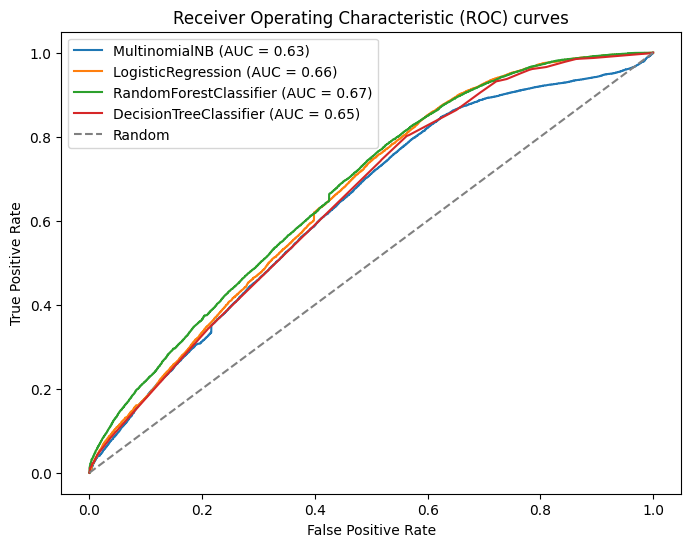

In [12]:
from vectorization import glove


def train_model_with_glove(models, train_df, test_df):
    plt.figure(figsize=(8, 6))
    
    x_train =[glove(text) for text in train_df.text]
    x_test = [glove(text) for text in test_df.text]

    # Pad the sequences to the same length
    x_train_padded = handle_uneven_sequences(x_train)
    x_test_padded = handle_uneven_sequences(x_test)

    x_train = np.mean(np.array(x_train_padded), axis=1)
    x_test = np.mean(np.array(x_test_padded), axis=1)


    for this_model in models:
        xtrain = x_train
        xtest = x_test
        if type(this_model).__name__ == "MultinomialNB":
            # Naive Bayes expects non-negative inputs
            scaler = MinMaxScaler()

            xtrain = scaler.fit_transform(xtrain)
            xtest = scaler.transform(xtest)
        model = this_model
        model.fit(xtrain, train_df.sentiment)
        pred_probs = model.predict_proba(xtest)[:, 1]
        fpr, tpr, thresholds = roc_curve(test_df.sentiment, pred_probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{type(this_model).__name__} (AUC = {roc_auc:.2f})')
        
        preds = model.predict(xtest)
        accuracy = accuracy_score(test_df.sentiment, preds)
        f1 = f1_score(test_df.sentiment, preds)
        
        print("model:", type(this_model).__name__)
        print(f"Accuracy = {accuracy}")
        print(f"F1 Score = {f1}")
        print("")
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) curves')
    plt.legend()
    plt.show()

train_model_with_glove(model_list, train_df, test_df)

#### TF-IDF Vectorizing with N-gram

model: MultinomialNB(alpha=0.01)
Accuracy = 0.804675
F1 Score = 0.8149586718139403

model: LogisticRegression(max_iter=200, solver='liblinear')
Accuracy = 0.83995
F1 Score = 0.8435407400166186

model: RandomForestClassifier(max_depth=10, random_state=42)
Accuracy = 0.72425
F1 Score = 0.7529453926443578

model: DecisionTreeClassifier(max_depth=5, min_samples_split=4, random_state=42)
Accuracy = 0.71435
F1 Score = 0.7315445702739533



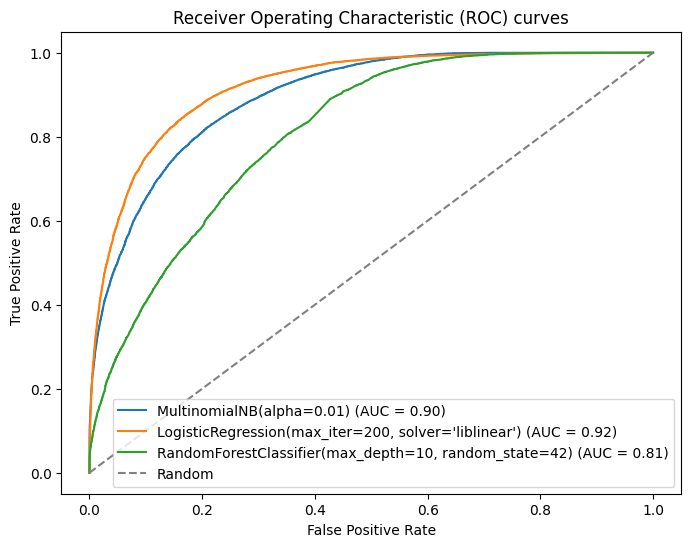

In [13]:
emb = TfidfVectorizer(
        tokenizer=word_tokenize, 
        token_pattern=None, 
        ngram_range=(1, 3)
    )
train_model(model_list,emb,train_df,test_df)

## Transformer based models

In [8]:
MAX_LEN = 512
BERT_MODEL = "bert-base-uncased"
# reduce lr on plateau

In [10]:
class BERTModel(nn.Module):
    """
        BERT model with a dropout and linear layer with 2 outputs
    """
    def __init__(self, bert_model, num_classes=2, dropout_rate=0.3):
        super(BERTModel, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(bert_model)
        self.drop = nn.Dropout(dropout_rate)
        self.out = nn.Linear(self.bert.config.hidden_size, num_classes)


    def forward(self, ids, mask, token_type_ids):
        _, pooled_output = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
        output = self.drop(pooled_output)
        return self.out(output)

In [11]:
def train(data, model, optimizer, device):
    """
        Train the model for one epoch
    """
    model.train()
    running_loss = 0.0

    for batch_idx, d in enumerate(data):
        mask = d['mask'].to(device, dtype=torch.long)
        ids = d['ids'].to(device, dtype=torch.long)
        token_type_ids = d['token_type_ids'].to(device, dtype=torch.long)
        targets = d['targets'].to(device, dtype=torch.long)
        optimizer.zero_grad()
        outputs = model(ids, mask, token_type_ids)

        loss = torch.nn.CrossEntropyLoss(outputs, targets) # Calculate loss
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0 and batch_idx !=0:
            temp = f'Batch index = {batch_idx}\tRunning Loss = {running_loss/10}'
            print(temp)
            running_loss = 0.0

In [12]:
# load the data
pos_path = 'data/twitter-datasets/train_pos.txt'
neg_path = 'data/twitter-datasets/train_neg.txt'

with open(pos_path, 'r') as f:
    pos_tweets = f.readlines()
with open(neg_path, 'r') as f:
    neg_tweets = f.readlines()

# TODO: preprocess data
# pos_tweets = preprocessing.remove_tags(pos_tweets)
# neg_tweets = preprocessing.remove_tags(neg_tweets)


pos_labels = [1 for _ in range(len(pos_tweets))]
neg_labels = [0 for _ in range(len(neg_tweets))]
labels = pos_labels + neg_labels
tweets = pos_tweets + neg_tweets

# Combine labels and tweets into a list of tuples
data = list(zip(tweets, labels))

# Shuffle the data
random.shuffle(data)

# Unpack the shuffled data back into separate lists
shuffled_tweets, shuffled_labels = zip(*data)

# Split the shuffled data into training and validation sets
train_tweets, val_tweets, train_labels, val_labels = train_test_split(shuffled_tweets, shuffled_labels, test_size=0.1)

In [13]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL, do_lower_case=True)
train_encodings = tokenizer(train_tweets, truncation=True, padding=True, max_length=MAX_LEN)
val_encodings = tokenizer(val_tweets, truncation=True, padding=True, max_length=MAX_LEN)


# tokenizer = TweetTokenizer()
# train_encodings = [tokenizer.tokenize(t) for t in train_tweets]
# val_encodings = [tokenizer.tokenize(t) for t in val_tweets]



class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)



In [14]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3  # Number of training epochs


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
criterion = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(train_loader) * num_epochs)


# Function to calculate accuracy
def calc_accuracy(preds, labels):
    _, predictions = torch.max(preds, dim=1)
    correct = (predictions == labels).float()
    acc = correct.sum() / len(correct)
    return acc

all_labels = []
all_predictions = []

# Training Loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    total_train_loss = 0
    total_train_acc = 0

    for step, batch in enumerate(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = criterion(outputs.logits, batch['labels'])
        acc = calc_accuracy(outputs.logits, batch['labels'])
        print(f"Step {step+1}/{len(train_loader)} - Loss: {loss.item()}, Accuracy: {acc.item()}")
        total_train_loss += loss.item()
        total_train_acc += acc.item()

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_acc = total_train_acc / len(train_loader)
    print(f"Epoch {epoch+1} - Train loss: {avg_train_loss}, Accuracy: {avg_train_acc}")

    # Validation Loop
    model.eval()
    total_val_accuracy = 0
    total_val_loss = 0

    for batch in val_loader:
        with torch.no_grad():
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = criterion(outputs.logits, batch['labels'])
            acc = calc_accuracy(outputs.logits, batch['labels'])

            total_val_loss += loss.item()
            total_val_accuracy += acc.item()

            # for overall metrics calculation
            preds = outputs.logits.argmax(dim=1).cpu().numpy()
            labels = batch['labels'].cpu().numpy()
            all_predictions.extend(preds)
            all_labels.extend(labels)

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_accuracy = total_val_accuracy / len(val_loader)
    print(f"Epoch {epoch+1} - Validation loss: {avg_val_loss}, Accuracy: {avg_val_accuracy}")

# After all epochs, calculate overall metrics
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
f1 = f1_score(all_labels, all_predictions, average='macro')

print("Training complete!")
print(f"Overall Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Step 1/22500 - Loss: 0.7299100160598755, Accuracy: 0.375
Step 2/22500 - Loss: 0.7326957583427429, Accuracy: 0.5
Step 3/22500 - Loss: 0.8679541349411011, Accuracy: 0.125
Step 4/22500 - Loss: 0.7152673006057739, Accuracy: 0.5
Step 5/22500 - Loss: 0.6850508451461792, Accuracy: 0.5
Step 6/22500 - Loss: 0.6123498678207397, Accuracy: 0.75
Step 7/22500 - Loss: 0.8654451370239258, Accuracy: 0.25
Step 8/22500 - Loss: 0.7086740732192993, Accuracy: 0.5
Step 9/22500 - Loss: 0.6956126689910889, Accuracy: 0.5
Step 10/22500 - Loss: 0.6566214561462402, Accuracy: 0.625
Step 11/22500 - Loss: 0.6987295150756836, Accuracy: 0.375
Step 12/22500 - Loss: 0.6939436197280884, Accuracy: 0.5
Step 13/22500 - Loss: 0.6760130524635315, Accuracy: 0.5
Step 14/22500 - Loss: 0.667831540107727, Accuracy: 0.5
Step 15/22500 - Loss: 0.653003454208374, Accuracy: 0.5
Step 16/22500 - Loss: 0.64644855260849, Accuracy: 0.5
Step 17/22500 - Loss: 0.8006994724273682, Accuracy: 0.125
Step 18/22500 - Loss: 0.660507321357727

KeyboardInterrupt: 

#### Possible improvement
1. Don't store all the scores in one variable, just store for each epoch and only keep the average score
2. save model for Each epoch

In [ ]:
torch.save(model, 'bert.pth')

In [ ]:
## predict
model = torch.load('bert.pth')

## use the test set
test_path = 'data/twitter-datasets/test_data.txt'
with open(test_path, 'r') as f:
    test_tweets = f.readlines()

test_encodings = tokenizer(test_tweets, truncation=True, padding=True, max_length=MAX_LEN)
test_dataset = TweetDataset(test_encodings, [0 for _ in range(len(test_tweets))])
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


model.eval()
predictions = []
for batch in test_loader:
    with torch.no_grad():
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = outputs.logits.argmax(dim=1).cpu().numpy()
        predictions.extend(preds)

In [ ]:
predictions = np.array(predictions)
predictions[predictions == 0] = -1

In [ ]:
print(predictions)

[-1 -1  1 ... -1  1 -1]


In [ ]:
import pandas as pd

submission = pd.DataFrame({'Id':range(1, len(predictions) + 1),'Prediction': predictions})
submission.to_csv('submission.csv', index=False)

In [1]:
MAX_LEN = 512
TWITTER_ROBERTA_MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
FOLDER_PATH = "/content/drive/MyDrive/Colab Notebooks/Machine learning/ML_project/"
# reduce lr on plateau

In [3]:
class ROBERTAModel(nn.Module):
    """
    RoBERTa model with a dropout and linear layer for binary text classification
    """
    def __init__(self, roberta_model, num_classes=2, dropout_rate=0.3):
        super(ROBERTAModel, self).__init__()
        self.roberta = AutoModelForSequenceClassification.from_pretrained(roberta_model)
        self.drop = nn.Dropout(dropout_rate)
        self.out = nn.Linear(self.roberta.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.roberta(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        output = self.drop(logits)
        return self.out(output)

In [5]:
def train(data, model, optimizer, device):
    """
        Train the model for one epoch
    """
    model.train()
    running_loss = 0.0

    for batch_idx, d in enumerate(data):
        mask = d['mask'].to(device, dtype=torch.long)
        ids = d['ids'].to(device, dtype=torch.long)
        token_type_ids = d['token_type_ids'].to(device, dtype=torch.long)
        targets = d['targets'].to(device, dtype=torch.long)
        optimizer.zero_grad()
        outputs = model(ids, mask, token_type_ids)

        loss = torch.nn.CrossEntropyLoss(outputs, targets) # Calculate loss
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0 and batch_idx !=0:
            temp = f'Batch index = {batch_idx}\tRunning Loss = {running_loss/10}'
            print(temp)
            running_loss = 0.0

In [7]:
pos_path = 'data/twitter-datasets/train_pos_full.txt'
neg_path = 'data/twitter-datasets/train_neg_full.txt'

with open(pos_path, 'r') as f:
    pos_tweets = f.readlines()
with open(neg_path, 'r') as f:
    neg_tweets = f.readlines()

# TODO: preprocess data
pos_tweets = [preprocess(tweet) for tweet in pos_tweets]
neg_tweets = [preprocess(tweet) for tweet in neg_tweets]


pos_labels = [1 for _ in range(len(pos_tweets))]
neg_labels = [0 for _ in range(len(neg_tweets))]
labels = pos_labels + neg_labels
tweets = pos_tweets + neg_tweets

# Combine labels and tweets into a list of tuples
data = list(zip(tweets, labels))

# Shuffle the data
random.shuffle(data)

# Unpack the shuffled data back into separate lists
train_tweets, train_labels = zip(*data)

# Use RoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained(TWITTER_ROBERTA_MODEL)

# Tokenize and convert to input IDs
train_encodings = tokenizer(train_tweets, truncation=True, padding=True, max_length=MAX_LEN, return_tensors="pt")

config.json: 100%|██████████| 929/929 [00:00<?, ?B/s] 
d:\APPS\Anaconda\envs\ML\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Ke\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
vocab.json: 100%|██████████| 899k/899k [00:00<00:00, 3.15MB/s]
merges.txt: 100%|██████████| 456k/

In [26]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)

In [ ]:
# Set k value
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

num_epoch = 1

model = AutoModelForSequenceClassification.from_pretrained(TWITTER_ROBERTA_MODEL)
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3  # Number of training epochs


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
criterion = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(train_dataset) * (k_folds-1))


# Function to calculate accuracy
def calc_accuracy(preds, labels):
    _, predictions = torch.max(preds, dim=1)
    correct = (predictions == labels).float()
    acc = correct.sum() / len(correct)
    return acc

all_labels = []
all_predictions = []

for fold, (train_indices, val_indices) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold + 1}/{k_folds}")

    # Create data loaders for the current fold
    train_fold_subset = torch.utils.data.Subset(train_dataset, train_indices)
    val_fold_subset = torch.utils.data.Subset(train_dataset, val_indices)
    train_loader = DataLoader(train_fold_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_fold_subset, batch_size=32, shuffle=False)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        total_train_loss = 0
        total_train_acc = 0

        for step, batch in enumerate(train_loader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = criterion(outputs.logits, batch['labels'])
            acc = calc_accuracy(outputs.logits, batch['labels'])
            print(f"Step {step+1}/{len(train_loader)} - Loss: {loss.item()}, Accuracy: {acc.item()}")
            total_train_loss += loss.item()
            total_train_acc += acc.item()

            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_acc = total_train_acc / len(train_loader)
        print(f"Epoch {epoch+1} - Train loss: {avg_train_loss}, Accuracy: {avg_train_acc}")

        # Validation Loop
        model.eval()
        total_val_accuracy = 0
        total_val_loss = 0

        for batch in val_loader:
            with torch.no_grad():
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = criterion(outputs.logits, batch['labels'])
                acc = calc_accuracy(outputs.logits, batch['labels'])

                total_val_loss += loss.item()
                total_val_accuracy += acc.item()

                # for overall metrics calculation
                preds = outputs.logits.argmax(dim=1).cpu().numpy()
                labels = batch['labels'].cpu().numpy()
                all_predictions.extend(preds)
                all_labels.extend(labels)

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_accuracy = total_val_accuracy / len(val_loader)
        print(f"Epoch {epoch+1} - Validation loss: {avg_val_loss}, Accuracy: {avg_val_accuracy}")

# After all folds, calculate overall metrics
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
f1 = f1_score(all_labels, all_predictions, average='macro')

print("Training complete!")
print(f"Overall Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

## Prediction
1. Don't store all the scores in one variable, just store for each epoch and only keep the average score
2. save model for Each epoch

In [28]:
torch.save(model, FOLDER_PATH + 'manipulated/bert.pth')

In [ ]:
## predict
model = torch.load(FOLDER_PATH + 'manipulated/bert.pth')

## use the test set
test_path = FOLDER_PATH +'data/twitter-datasets/test_data.txt'
with open(test_path, 'r') as f:
    test_tweets = f.readlines()

test_encodings = tokenizer(test_tweets, truncation=True, padding=True, max_length=MAX_LEN)
test_dataset = TweetDataset(test_encodings, [0 for _ in range(len(test_tweets))])
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


model.eval()
predictions = []
for batch in test_loader:
    with torch.no_grad():
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = outputs.logits.argmax(dim=1).cpu().numpy()
        predictions.extend(preds)

In [ ]:
predictions = np.array(predictions)
predictions[predictions == 0] = -1

In [ ]:
print(predictions)

In [ ]:
submission = pd.DataFrame({'Id':range(1, len(predictions) + 1),'Prediction': predictions})
submission.to_csv(FOLDER_PATH + 'manipulated/roberta_submission.csv', index=False)